### In this lesson, I am going to build, train and evaluate Convolution Neural Newtwork to classify images of Traffic Signs.

In [1]:
!git clone https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project

fatal: destination path 'CarND-Traffic-Sign-Classifier-Project' already exists and is not an empty directory.


In [2]:
import os
import pickle
import zipfile
import warnings
import cv2 as cv
import numpy as np
import pandas as pd


import seaborn as sns
from matplotlib import pyplot as plt

import torch 
import torchvision
from torch import nn
import albumentations as A
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score


warnings.simplefilter('ignore')
ZIP_FILE_PATH = 'traffic-signs-data.zip'
config = {
    'TRAIN_BATCH_SIZE': 1024,
    'TEST_BATCH_SIZE' : 1024,
    'EPOCHS'          : 30,
    'LR'              : 1e-2,
    'LOG_MSG_SCALE'   : 1 
}

# Load Data

In [3]:
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip

--2022-12-13 18:21:32--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.112
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip.3’

traffic-signs-data. 100%[===================>] 117.80M  36.5MB/s    in 3.6s    

2022-12-13 18:21:36 (32.5 MB/s) - ‘traffic-signs-data.zip.3’ saved [123524425/123524425]



In [4]:
with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as file:
  file.extractall()


with open('train.p', 'rb') as f:
  train = pickle.load(f)

with open('valid.p', 'rb') as f:
  valid = pickle.load(f)

with open('test.p', 'rb') as f:
  test = pickle.load(f)


train_shape = train['features'].shape
valid_shape = valid['features'].shape
test_shape = test['features'].shape 

label_names = pd.read_csv('CarND-Traffic-Sign-Classifier-Project/signnames.csv', index_col='ClassId')
label_names.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


# Visualize some images

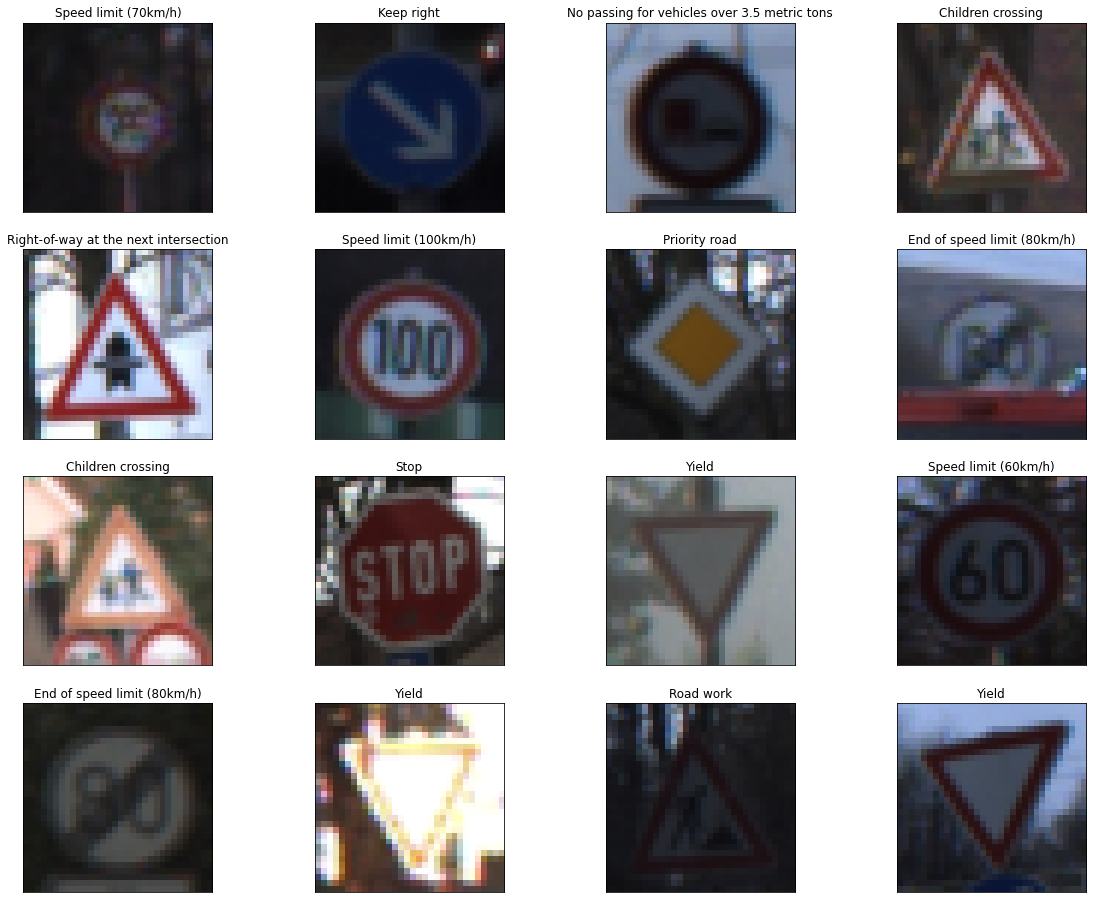

In [5]:
def visualize_images(rows, cols, images, indices, titles=None, cmap=None):
  plt.figure(figsize=(20, 16))
  for i in range(rows*cols):
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(images[indices[i]], cmap=cmap)
    plt.xticks([]);plt.yticks([])
    if titles is not None:
      plt.title(titles[i])

rows, cols = 4, 4
indices = np.random.randint(0, train_shape[0], rows*cols)
labels_numbers = [label for label in train['labels'][indices]]
labels = [*map(lambda x : x[0], label_names.iloc[labels_numbers].values)]
visualize_images(rows, cols, train['features'], indices, labels)

# Prepare data

In [6]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(train['labels'].reshape(-1, 1))


gray_train = 0.299 * train['features'][:, :, :, 0] + 0.587 * train['features'][:, :, :, 1] + 0.114 * train['features'][:, :, :, 2]

def preprocess(X):
    # convert from RGB to YUV
    X = np.array([np.expand_dims(cv.cvtColor(rgb_img, cv.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

    # adjust image contrast
    X = np.array([np.expand_dims(cv.equalizeHist(np.uint8(img)), 2) for img in X])

    # get images mean
    X = np.float32(X).reshape(-1, 32, 32)

    # standardize features
    print(X.shape)
    X -= np.mean(gray_train, axis=0).reshape(1, 32, 32)
    X /= (np.std(gray_train, axis=0) + np.finfo('float32').eps)
    return X

In [7]:
class Sign_Images():
  def __init__(self, images, labels, train=False):
    self.train = train
    self.X = images
    self.y = labels
    self.y = ohe.transform(self.y.reshape(-1, 1)).toarray()

  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, idx):
    if isinstance(idx, torch.Tensor):
      idx = idx.tolist()
    
    # data augmentation
    x = self.X[idx]
    if self.train:
      x = torch.Tensor(x)
    else :
      x = torch.Tensor(x)
    y = torch.Tensor(self.y[idx])
    return x, y


preprocessed_train = preprocess(train['features'])
preprocessed_valid = preprocess(valid['features'])
preprocessed_test = preprocess(test['features'])


train_loader = Sign_Images(preprocessed_train, train['labels'], train=True)
valid_loader = Sign_Images(preprocessed_valid, valid['labels'])
test_loader = Sign_Images(preprocessed_test, test['labels'])

trainloader = DataLoader(train_loader, batch_size=config['TRAIN_BATCH_SIZE'], shuffle=True)
validloader = DataLoader(valid_loader, batch_size=config['TEST_BATCH_SIZE'], shuffle=False)
testloader = DataLoader(test_loader, batch_size=config['TEST_BATCH_SIZE'], shuffle=False)

(34799, 32, 32)
(4410, 32, 32)
(12630, 32, 32)


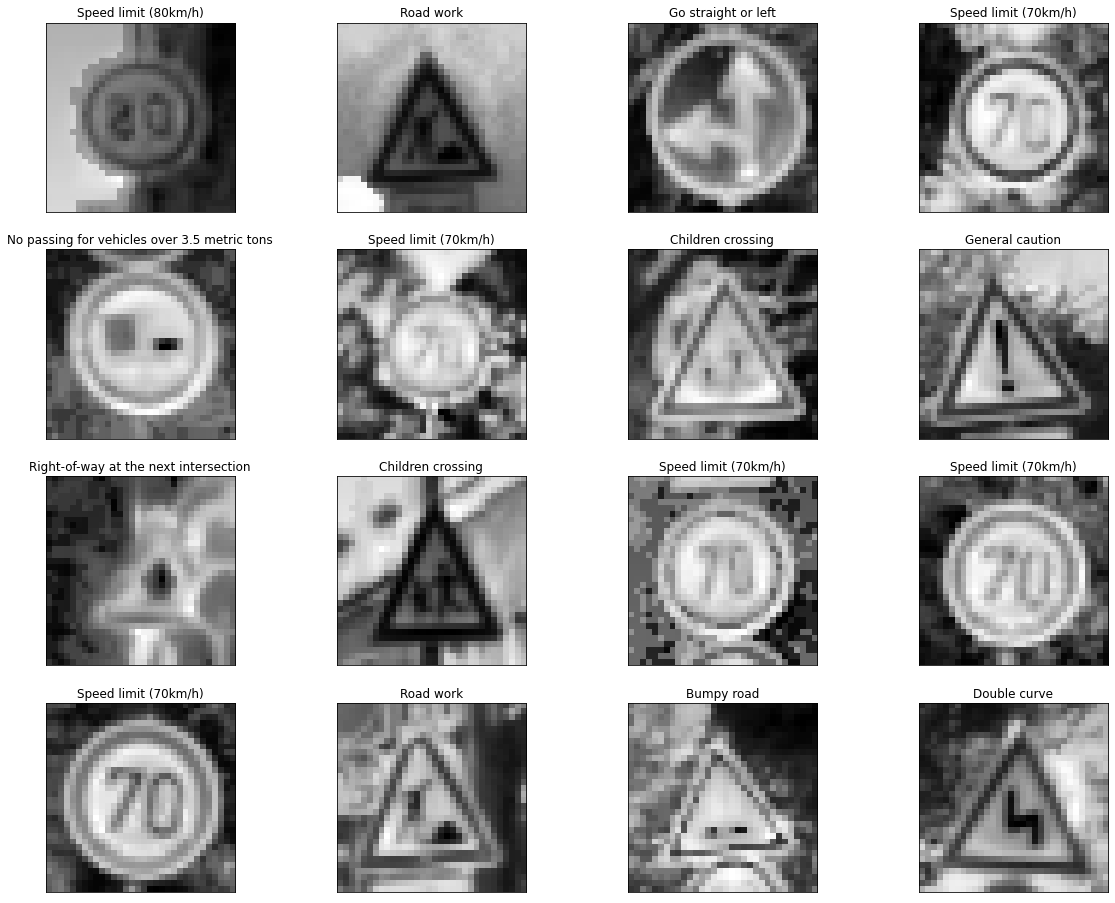

In [8]:
def visualize_from_dataloader(dataloader, rows, cols):
  for data, target in dataloader:
    indices = np.random.randint(0, len(data), rows*cols)
    data = data.view(-1, 32, 32).detach().numpy()
    target = target.detach().numpy()
    target = target.argmax(axis=1)
    labels = [target[i] for i in indices]
    titles = [label_names.iloc[i].values[0] for i in labels]
    visualize_images(4, 4, data, indices, titles, cmap='gray')
    break

visualize_from_dataloader(trainloader, 4, 4)

# Build model

In [9]:
class LeNet(nn.Module):
    def __init__(self, smx=True):
      super(LeNet, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
      self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

      self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
      self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

      self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0, stride=1)
      
      self.fc1 = nn.Linear(in_features=120, out_features=84)
      self.fc2 = nn.Linear(in_features=84, out_features=43)

      self.Act = nn.Tanh()
      self.softmax = nn.Softmax(1)
      self.smx = smx
    def forward(self, input_image):
      x = self.conv1(input_image)
      x = self.Act(x)
      x = self.avg_pool1(x)

      x = self.conv2(x)
      x = self.Act(x)
      x = self.avg_pool2(x)

      x = self.conv3(x)
      x = self.Act(x)

      x = x.view(-1, 120)
      x = self.fc1(x)
      x = self.Act(x)

      x = self.fc2(x)
      if self.smx:
        out = self.softmax(x)
      else :
        out = x

      return out

    def conv1_feature_maps(self, x):
      x = self.conv1(x)
      x = self.Act(x)
      x = self.avg_pool1(x)
      return x
    
    def conv2_feature_maps(self, x):
      x = self.conv1_feature_maps(x)
      x = self.conv2(x)
      x = self.Act(x)
      x = self.avg_pool2(x)
      return x
    
    def conv3_feature_maps(self, x):
      x = self.conv2_feature_maps(x)
      x = self.conv3(x)
      x = self.Act(x)
      return x


torch_model = LeNet(smx=False)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.01)


# Training

In [10]:
TRAIN_STEPS_PER_EPOCH = train_shape[0] // config['TRAIN_BATCH_SIZE']
VALID_STEPS_PER_EPOCH = valid_shape[0] // config['TEST_BATCH_SIZE']

history = {
    'loss'     : [], 
    'val_loss' : [], 
    'val_accuracy' : []
}

print("Training ....\n")
for epoch in range(config['EPOCHS']):
  trainl = []
  if epoch > 20:
    config['LR'] = 1e-3
  
  for idx, (data, target) in enumerate(trainloader):
    
    optimizer.zero_grad()
    y_hat = torch_model.forward(data.view(-1, 1, 32, 32))
    l = loss(y_hat, target)
    trainl.append(l.detach().numpy())
    l.backward()

    optimizer.step()

    LOG = f"{f'[info]: epoch:{epoch+1}'.ljust(20)}|{'='.ljust(idx // config['LOG_MSG_SCALE'], '=')}>{' '.ljust((TRAIN_STEPS_PER_EPOCH-idx) // config['LOG_MSG_SCALE'])}|\t loss: {l}"
    print("\r", end=LOG)

  history['loss'].append(np.mean(trainl))
  
  # evaluation
  with torch.no_grad():
    y_pred = nn.Softmax()(torch_model.forward(torch.Tensor(preprocessed_valid).view(-1, 1, 32, 32)))
    y_true = valid['labels']
    l = loss(torch.Tensor(ohe.transform(y_true.reshape(-1, 1)).toarray()), y_pred)
    acc = accuracy_score(y_pred.argmax(axis=1), valid["labels"]) * 100
    history['val_loss'].append(l)
    history['val_accuracy'].append(acc)

    LOG = f"{f'[info]: epoch:{epoch+1}'.ljust(20)}|{'='.ljust(idx // config['LOG_MSG_SCALE'], '=')}>{' '.ljust((TRAIN_STEPS_PER_EPOCH-idx) // config['LOG_MSG_SCALE'])}|\t {'Validation Loss'.rjust(30)}: {l}\
    \tvalidation accuracy: {acc}"
    print("\r", end=LOG)

    print('')

Training ....

[info]: epoch:1     |=================================> |	                Validation Loss: 3.193057060241699    	validation accuracy: 73.65079365079366
[info]: epoch:2     |=================================> |	                Validation Loss: 3.0081934928894043    	validation accuracy: 86.73469387755102
[info]: epoch:3     |=================================> |	                Validation Loss: 2.9615299701690674    	validation accuracy: 89.90929705215419
[info]: epoch:4     |=================================> |	                Validation Loss: 2.9382705688476562    	validation accuracy: 90.31746031746032
[info]: epoch:5     |=================================> |	                Validation Loss: 2.9328033924102783    	validation accuracy: 90.47619047619048
[info]: epoch:6     |=================================> |	                Validation Loss: 2.9212918281555176    	validation accuracy: 90.77097505668934
[info]: epoch:7     |=================================> |	          

Acc Score: 92.99319727891157


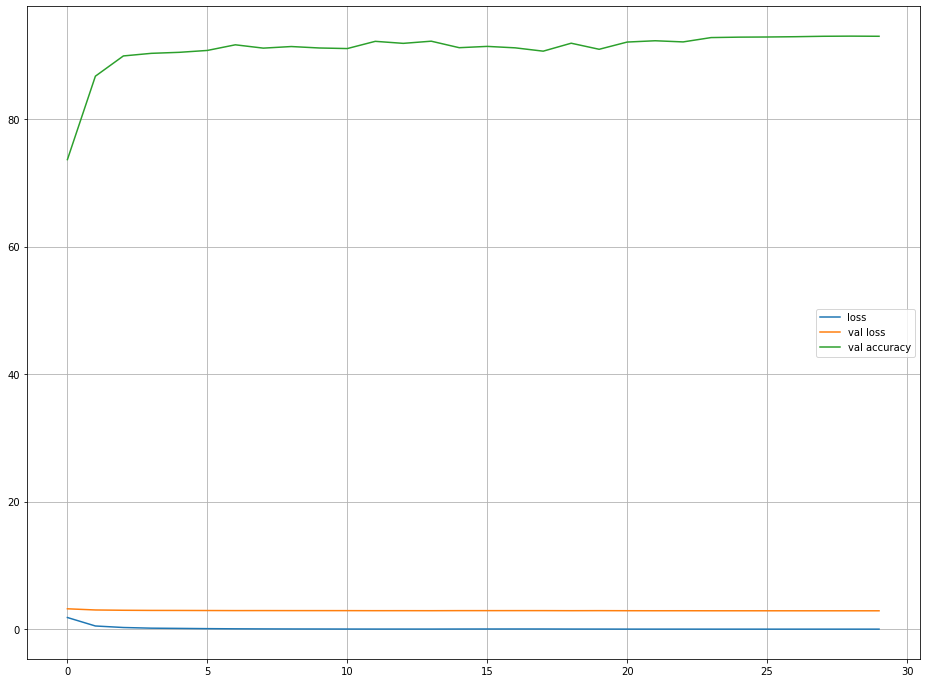

In [11]:
y_pred = nn.Softmax()(torch_model.forward(torch.Tensor(preprocessed_valid).view(-1, 1, 32, 32))).detach().numpy()
print(f'Acc Score: {accuracy_score(y_pred.argmax(axis=1), valid["labels"]) * 100}')


# plot graph
plt.figure(figsize=(16, 12))
x = range(len(history['loss']))
plt.plot(x, history['loss'], label='loss')
plt.plot(x, history['val_loss'], label='val loss')
plt.plot(x, history['val_accuracy'], label='val accuracy')
plt.legend(loc='right')
plt.grid()
plt.show();

# Test Model 

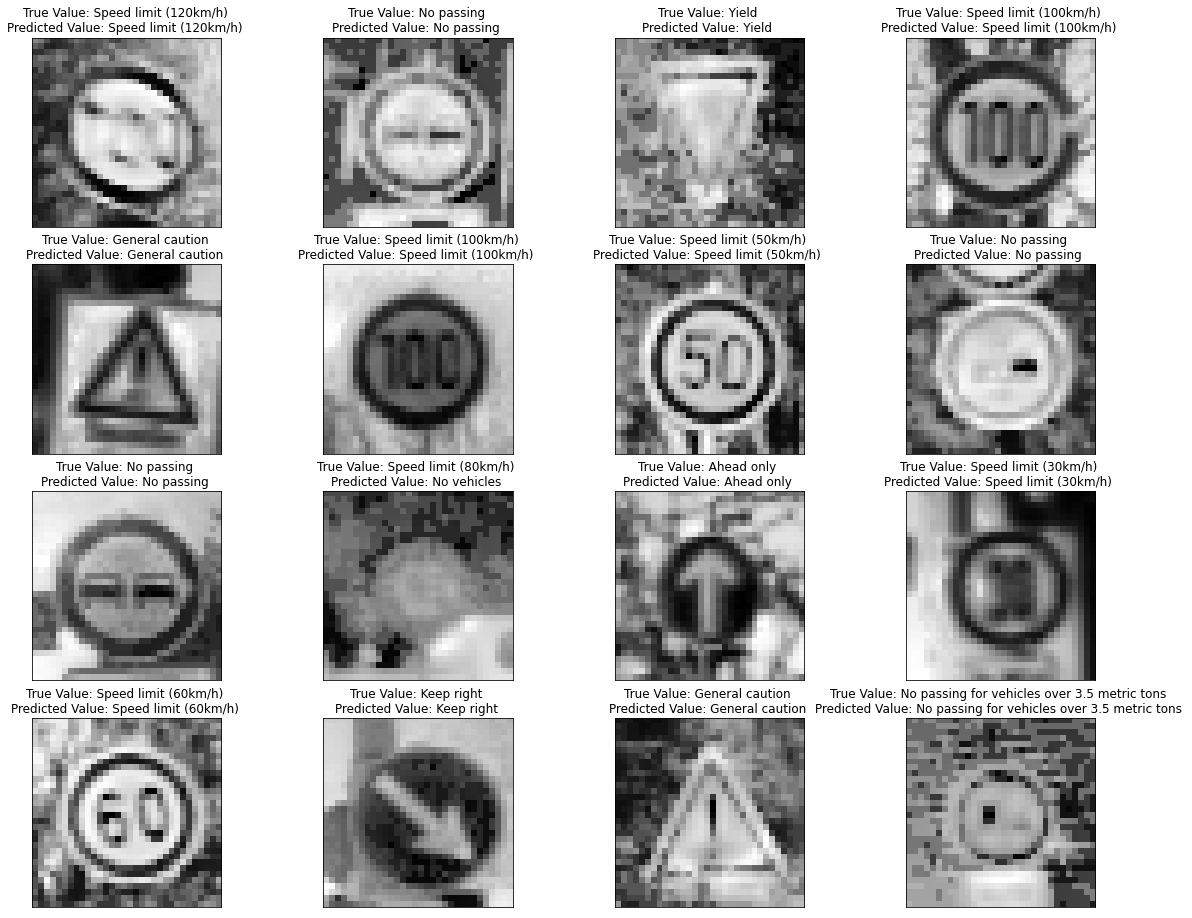

In [12]:
for data, target in testloader:
  indices = np.random.randint(0, config['TEST_BATCH_SIZE'], rows*cols)
  test = data[indices]
  y_true = target[indices]
  y_true = ohe.inverse_transform(y_true)

  y_pred = nn.Softmax()(torch_model.forward(test.view(-1, 1, 32, 32))).argmax(axis=1)
  y_true_label = [label_names.iloc[i[0], 0] for i in y_true]
  y_pred_label = [label_names.iloc[i, 0] for i in y_pred.detach().numpy()]
  titles = [f"True Value: {true} \nPredicted Value: {pred} " for true , pred in zip(y_true_label, y_pred_label)]
  visualize_images(rows, cols, data.detach().numpy(), indices, titles, cmap='gray')
  break


# Visualize Feature Maps after certain layer:

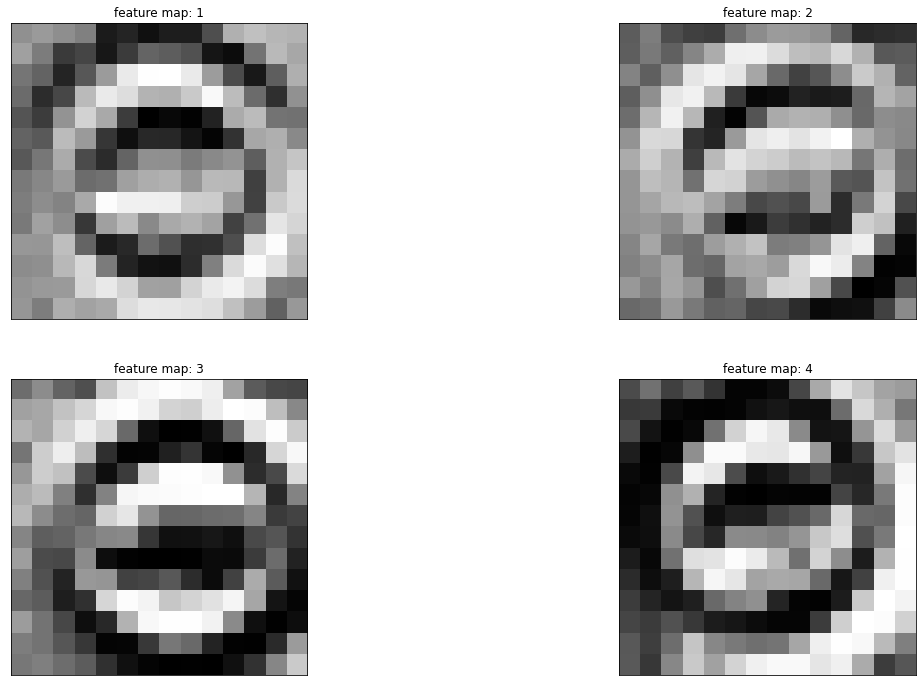

In [13]:
# feature maps after first convolution
sample = preprocessed_test[0].reshape(-1 ,1, 32, 32)

feature_maps = torch_model.conv1_feature_maps(torch.Tensor(sample)).detach().numpy()
n_feature_maps = feature_maps.shape[1]
rows, cols = int(np.sqrt(n_feature_maps)), int(np.sqrt(n_feature_maps))

fig, axs = plt.subplots(rows, cols, figsize=(20, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(feature_maps[0, i].reshape(*feature_maps.shape[2:]), cmap='gray')
  ax.set_title(f'feature map: {i+1}')
  ax.set_xticks([]);ax.set_yticks([])
